# load 12 month data and call bias, mae, rmse on model grid and then regrid to lat lon file

In [1]:
import xarray as xr  
import time 
import argparse, sys
import os 
import time 
import numpy as np
import subprocess

In [2]:
def build_var_list(ds, orivar1,orivar2):
    err_var = []
    for i,sv in enumerate(orivar1):
        if sv in list(ds.variables) : 
            # check nn var
            if orivar2[i] in list(ds.variables) : 
                err_var.append([sv,orivar2[i]]) 
            else:
                raise Exception(f'{orivar2[i]} do not exist in data file. Please check!')
        else:
            raise Exception(f'{sv} do not exist in data file. Please check!')
    return err_var
def regrid_6tile2latlon(var_list,root,output_name):
    '''run fregrid in subshell'''
    print('Calling fregrid in subshell ... ', end='  ')
    var_list_str = ','.join(var_list)
    cmd = f"cd {root}/rad_double_call_err;"\
         +f"cp {root}/regrid/* . ;"\
         +f"bash run_fregrid.sh {output_name} {var_list_str};"
    # \
    #      +f"rm {output_name}.tile*"
    tmp=subprocess.run([cmd], shell=True, capture_output=True)
    if tmp.stderr.decode("utf-8") != '': 
        raise Exception(tmp.stderr.decode("utf-8")) 
    # print(tmp.stdout.decode("utf-8"))
    regrid_file_path = f'{root}/rad_double_call_err/{output_name}.nc'
    print('Done.')
    return regrid_file_path

In [3]:
ori_var = [
    'olr_clr',
    'olr',
    'lwdn_sfc',
    'swup_toa',
    'swdn_sfc',
    'swup_sfc',
    'tdt_lw',
    'tdt_sw',
]
ori_var_ad = [
    'olr_af_clr',
    'olr_af',
    'lwdn_sfc_af',
    'swup_toa_af',
    'swdn_sfc_af',
    'swup_sfc_af',
    'tdt_lw_af',
    'tdt_sw_af',
]
if __name__ == '__main__':  
    ##################################################### 
    # parser=argparse.ArgumentParser()
    # parser.add_argument("--filename", help="filepattern, hourly, daily file name before .nc") 
    # args=parser.parse_args()
    # filename = args.filename 
    file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE'
    tmp=subprocess.run([f'mkdir -p {file_path}/rad_double_call_err'], shell=True, capture_output=True)
    if tmp.stderr.decode("utf-8") != '': 
        raise Exception(tmp.stderr.decode("utf-8")) 
    year = 2000
    for ti in range(1,7):
        filenames = [f'{file_path}/HISTORY/{year}{m:02d}01.atmos_8xdaily.tile{ti}.nc' for m in range(1,13)] 
        # filenames = [f'{file_path}/HISTORY/{year}{m:02d}01.atmos_8xdaily.tile{ti}.nc' for m in range(1,7)] 
 
        with xr.open_mfdataset(filenames) as ds: 
            var_list=build_var_list(ds, ori_var,ori_var_ad)
            olr = ds['olr'].load()
            ds_new = olr.to_dataset().groupby('time.month').mean('time')
            sta_time = time.time()
            for svar in var_list:
                print(f'{svar} ... ', end='')
                var1 = ds[svar[0]].load() 
                var2 = ds[svar[1]].load() 
                ds_new[svar[0]] = var1.groupby('time.month').mean('time')
                ds_new[f'{svar[0]}_dc'] = var2.groupby('time.month').mean('time')
                err = var1 - var2
                ds_new[f'bias_{svar[0]}'] = err.groupby('time.month').mean('time')
                ds_new[f'mae_{svar[0]}'] = abs(err).groupby('time.month').mean('time')
                ds_new[f'rmse_{svar[0]}'] = ((err**2).groupby('time.month').mean('time'))**0.5 
            print(f' Done. Use time: {time.time() - sta_time: 3.0f}s')
            # add time axis
            ds_new = ds_new.rename({'month':'time'}) 
            new_time = xr.concat([_[1][0] for _ in ds.time.groupby('time.month')],dim='time')
            ds_new['time'] = new_time
            newfilename = f"{file_path}/rad_double_call_err/dc_{year}.monavg.tile{ti}.nc"
            ds_new['phalf'] = ds['phalf']
            ds_new.to_netcdf(newfilename) 

['olr_clr', 'olr_af_clr'] ... ['olr', 'olr_af'] ... ['lwdn_sfc', 'lwdn_sfc_af'] ... ['swup_toa', 'swup_toa_af'] ... ['swdn_sfc', 'swdn_sfc_af'] ... ['swup_sfc', 'swup_sfc_af'] ... ['tdt_lw', 'tdt_lw_af'] ... ['tdt_sw', 'tdt_sw_af'] ...  Done. Use time:  87s
['olr_clr', 'olr_af_clr'] ... ['olr', 'olr_af'] ... ['lwdn_sfc', 'lwdn_sfc_af'] ... ['swup_toa', 'swup_toa_af'] ... ['swdn_sfc', 'swdn_sfc_af'] ... ['swup_sfc', 'swup_sfc_af'] ... ['tdt_lw', 'tdt_lw_af'] ... ['tdt_sw', 'tdt_sw_af'] ...  Done. Use time:  86s
['olr_clr', 'olr_af_clr'] ... ['olr', 'olr_af'] ... ['lwdn_sfc', 'lwdn_sfc_af'] ... ['swup_toa', 'swup_toa_af'] ... ['swdn_sfc', 'swdn_sfc_af'] ... ['swup_sfc', 'swup_sfc_af'] ... ['tdt_lw', 'tdt_lw_af'] ... ['tdt_sw', 'tdt_sw_af'] ...  Done. Use time:  86s
['olr_clr', 'olr_af_clr'] ... ['olr', 'olr_af'] ... ['lwdn_sfc', 'lwdn_sfc_af'] ... ['swup_toa', 'swup_toa_af'] ... ['swdn_sfc', 'swdn_sfc_af'] ... ['swup_sfc', 'swup_sfc_af'] ... ['tdt_lw', 'tdt_lw_af'] ... ['tdt_sw', 'tdt_sw

In [4]:
ds_new

<xarray.Dataset>
Dimensions:        (grid_xt: 96, grid_yt: 96, time: 12, pfull: 33, phalf: 34)
Coordinates:
  * grid_xt        (grid_xt) float64 1.0 2.0 3.0 4.0 5.0 ... 93.0 94.0 95.0 96.0
  * grid_yt        (grid_yt) float64 1.0 2.0 3.0 4.0 5.0 ... 93.0 94.0 95.0 96.0
  * time           (time) object 2000-01-01 03:00:00 ... 2000-12-01 00:00:00
  * pfull          (pfull) float64 2.164 5.845 10.75 17.11 ... 985.4 992.8 997.9
  * phalf          (phalf) float64 1.0 4.0 8.186 13.79 ... 989.7 995.9 1e+03
Data variables: (12/40)
    olr            (time, grid_yt, grid_xt) float32 245.5 246.0 ... 259.3 260.6
    olr_clr        (time, grid_yt, grid_xt) float32 271.6 271.6 ... 276.2 276.7
    olr_clr_dc     (time, grid_yt, grid_xt) float32 271.6 271.6 ... 276.2 276.7
    bias_olr_clr   (time, grid_yt, grid_xt) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mae_olr_clr    (time, grid_yt, grid_xt) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rmse_olr_clr   (time, grid_yt, grid_xt) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...             ...
    rmse_tdt_lw    (time, pfull, grid_yt, grid_xt) float32 4.369e-07 ... 3.93...
    tdt_sw         (time, pfull, grid_yt, grid_xt) float32 0.0001347 ... 9.73...
    tdt_sw_dc      (time, pfull, grid_yt, grid_xt) float32 0.000135 ... 9.811...
    bias_tdt_sw    (time, pfull, grid_yt, grid_xt) float32 -2.941e-07 ... -7....
    mae_tdt_sw     (time, pfull, grid_yt, grid_xt) float32 8.318e-07 ... 9.36...
    rmse_tdt_sw    (time, pfull, grid_yt, grid_xt) float32 1.807e-06 ... 2.22...

In [5]:
tmp1 = ds['tdt_sw']
tmp2 = ds['tdt_sw_af']

In [6]:
tmp1[100,:,10,10],tmp2[100,:,10,10]


(<xarray.DataArray 'tdt_sw' (pfull: 33)>
 array([1.83871365e-04, 7.92648716e-05, 5.25824107e-05, 3.66758359e-05,
        2.66434199e-05, 1.99033002e-05, 1.46087277e-05, 9.75837065e-06,
        6.48244622e-06, 5.04654645e-06, 4.73515411e-06, 9.60735633e-06,
        3.61219172e-05, 2.23318548e-05, 1.15310995e-05, 2.29283569e-06,
        3.76791809e-06, 3.27775979e-06, 4.89965623e-06, 5.47022410e-06,
        5.37002643e-06, 5.21867605e-06, 3.70339876e-06, 2.80592621e-06,
        1.24067901e-06, 2.59661351e-06, 7.33394381e-06, 6.85693021e-06,
        7.44366525e-06, 7.33148772e-06, 7.16275099e-06, 7.06178389e-06,
        7.02515172e-06], dtype=float32)
 Coordinates:
     grid_xt  float64 11.0
     grid_yt  float64 11.0
     time     object 2000-01-13 15:00:00
   * pfull    (pfull) float64 2.164 5.845 10.75 17.11 ... 975.6 985.4 992.8 997.9
 Attributes:
     units:         deg_K/sec
     long_name:     temperature tendency for SW radiation
     cell_methods:  time: point,
 <xarray.DataArray

## regrid to lat lon

In [7]:
ll /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc*

-rw-r--r-- 1 cw55 537282557 Oct 15 00:10 /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc_2000.monavg.nc
-rw-r--r-- 1 cw55 159309823 Oct 15 00:16 /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc_2000.monavg.tile1.nc
-rw-r--r-- 1 cw55 159309823 Oct 15 00:17 /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc_2000.monavg.tile2.nc
-rw-r--r-- 1 cw55 159309823 Oct 15 00:19 /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc_2000.monavg.tile3.nc
-rw-r--r-- 1 cw55 159309823 Oct 15 00:21 /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc_2000.monavg.tile4.nc
-rw-r--r-- 1 cw55 159309823 Oct 15 00:22 /scratch/gpfs/cw55/AM4/work/CTL2000_rad_double_call_stellarcpu_intelmpi_22_768PE/rad_double_call_err/dc_2000.monavg.tile5.nc
-rw-r--r--

In [8]:
    var_list_err = []
    for svar in ori_var:
        var_list_err.append(svar)
        var_list_err.append(f'{svar}_dc')
        var_list_err.append(f'bias_{svar}')
        var_list_err.append(f'mae_{svar}')
        var_list_err.append(f'rmse_{svar}')
    regrid_file_path = regrid_6tile2latlon(var_list_err, file_path, f'dc_{year}.monavg')

Calling fregrid in subshell ...   Done.


# plot on maps

In [9]:
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
plt.rcParams['font.size'] = '6'

In [10]:
# for err_ind in ['bias','mae','rmse']:
#     fig, axs = plt.subplots(nrows=2,ncols=3,
#                             figsize=(6,3), dpi=200)
#     axs = axs.flatten() 
#     for si, svar in enumerate(var_list):
#         print(svar)
#         var_name = svar[0]
#         ds_plot = ds_new[f'{err_ind}_{var_name}'].mean('time')
#         level = np.array([-4,-2,-1,-0.5,-0.2,0, 0.2, 0.5, 1, 2, 4 ])
#         # level = np.arange(-5,5.1,0.5)
#         # if sky_cond[mo] == 'all':  level = level*2
#         ax=axs[si] 
#         ds_plot.plot(ax=ax, levels=level, extend='both') 
#         ax.set(xlabel=None,ylabel=None) 
#         ax.set_title(f'{var_name}  {err_ind} : {ds_plot.mean().values:4.2f} ') 
#     fig.tight_layout()

olr_clr
olr
lwdn_sfc
swup_toa
swdn_sfc
swup_sfc
olr_clr
olr
lwdn_sfc
swup_toa
swdn_sfc
swup_sfc
olr_clr
olr
lwdn_sfc
swup_toa
swdn_sfc
swup_sfc


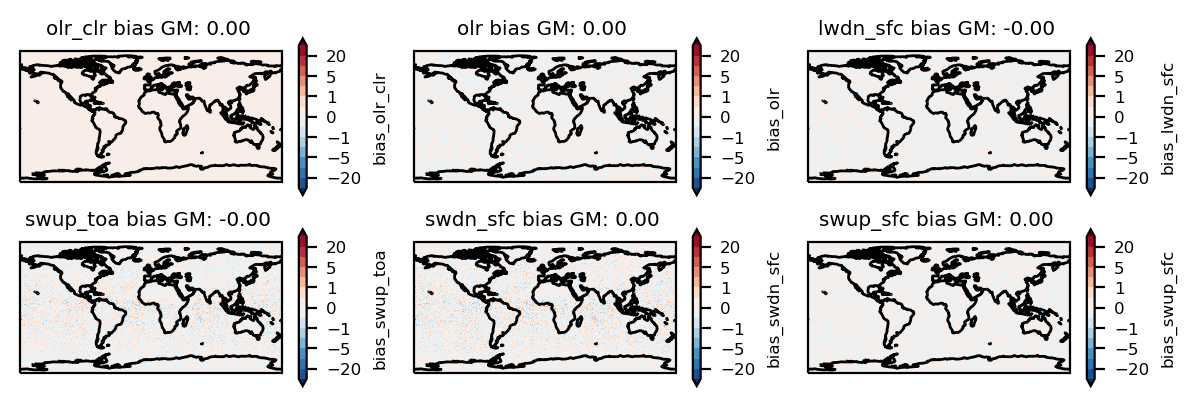

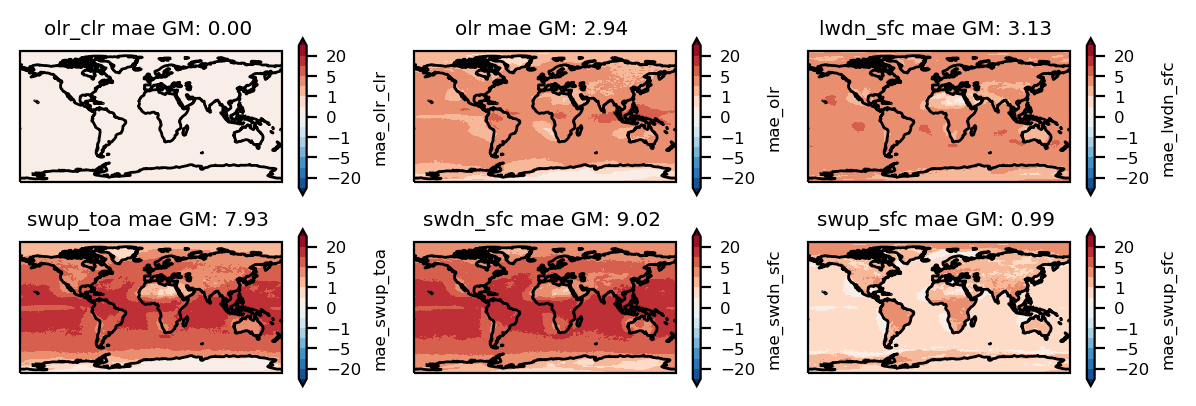

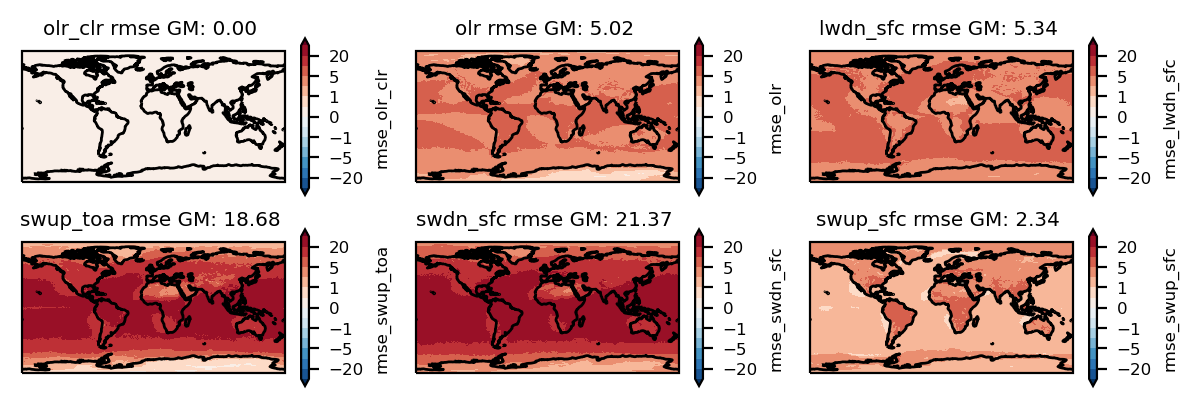

In [11]:
ds_re = xr.open_dataset(regrid_file_path)
ds_re
for err_ind in ['bias','mae','rmse']:
    fig, axs = plt.subplots(nrows=2,ncols=3,
                            figsize=(6,2), dpi=200,
                            subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten() 
    for si, svar in enumerate(ori_var[:-2]):
        print(svar)
        var_name = svar
        ds_plot = ds_re[f'{err_ind}_{var_name}'].mean('time').rename({'grid_yt':'lat', 'grid_xt':'lon'})
        level = np.array([-50, -20, -10, -5,-2,-1,-0.5,0,0.5,1,2,5,10,20,50])  
        if ('mae' == err_ind) or ('rmse' == err_ind) :
            ds_plot = ds_plot/np.sqrt(2)
        ax=axs[si] 
        ds_plot.plot(ax=ax, levels=level, extend='both') 
        ax.set(xlabel=None,ylabel=None) 
        gm_value = global_mean_xarray(ds_plot).values
        ax.set_title(f'{var_name} {err_ind} GM: {gm_value:4.2f} ') 
        ax.coastlines()
    fig.tight_layout()

# Heating rate profile

In [12]:
# vertical level is hybrid pressure
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

tdt_lw
tdt_sw


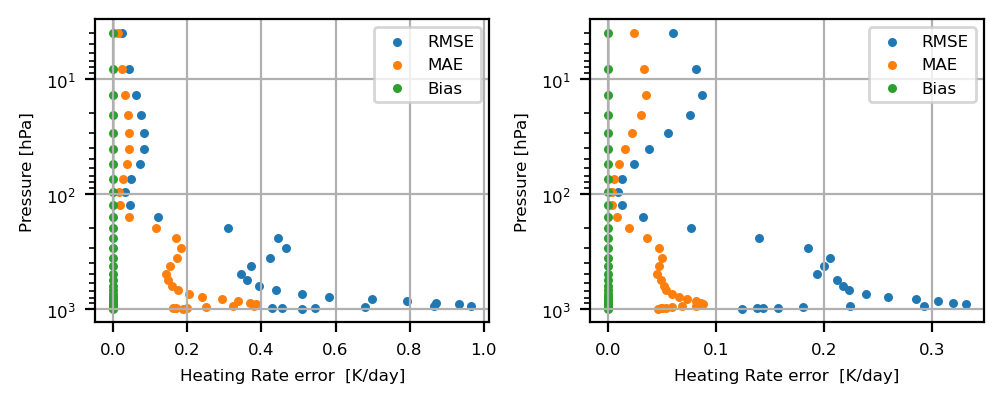

In [13]:
    # plt.style.use('default')
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2),dpi=200) 
    axs=axs.flatten()     
    for si, svar in enumerate(['tdt_lw','tdt_sw']):
        ax = axs[si]
        print(svar)
        var_name = svar
        RMSE = global_mean_xarray(ds_re[f'rmse_{var_name}'].mean('time')\
                                  .rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400/np.sqrt(2)
        MAE  = global_mean_xarray(ds_re[f'mae_{var_name}'] .mean('time')\
                                  .rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400/np.sqrt(2)
        Bias = global_mean_xarray(ds_re[f'bias_{var_name}'].mean('time')\
                                  .rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400/np.sqrt(2)
        Mean = global_mean_xarray(ds_re[var_name].mean('time').rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400
        
        ax.set_prop_cycle(None)
        ax.scatter(RMSE, z_lev[1:],  s=5, label='RMSE')
        ax.scatter(MAE , z_lev[1:],  s=5, label='MAE') 
        ax.scatter(Bias, z_lev[1:],  s=5, label='Bias')
        # ax.scatter(Mean, z_lev[1:],  s=5, label='Mean')
        ax.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
        ax.legend(fontsize=6)
        ax.invert_yaxis()
        ax.set_yscale('log') 
        ax.grid(True)
    #     ax4.set_xlim([-0.04,0.4])
        ax.set_xlabel('Heating Rate error  [K/day]')
        ax.set_ylabel('Pressure [hPa]') 
        fig.tight_layout()
        fig.show() 

# normalized

tdt_lw
tdt_sw


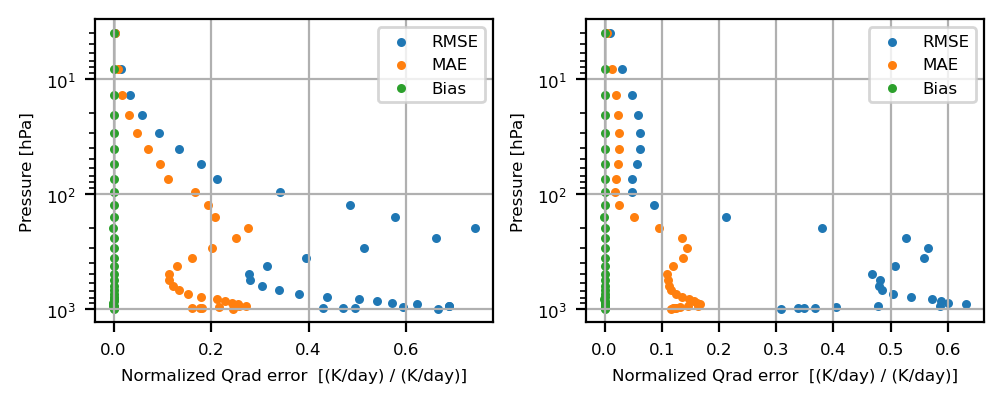

In [14]:
    # plt.style.use('default')
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2),dpi=200) 
    axs=axs.flatten()     
    for si, svar in enumerate(['tdt_lw','tdt_sw']):
        ax = axs[si]
        print(svar)
        var_name = svar
        RMSE = global_mean_xarray(ds_re[f'rmse_{var_name}'].mean('time').rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400
        MAE  = global_mean_xarray(ds_re[f'mae_{var_name}'] .mean('time').rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400
        Bias = global_mean_xarray(ds_re[f'bias_{var_name}'].mean('time').rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400
        Mean = global_mean_xarray(ds_re[var_name].mean('time').rename({'grid_yt':'lat', 'grid_xt':'lon'}))*86400
        
        ax.set_prop_cycle(None)
        ax.scatter(RMSE/abs(Mean), z_lev[1:],  s=5, label='RMSE')
        ax.scatter(MAE /abs(Mean), z_lev[1:],  s=5, label='MAE') 
        ax.scatter(Bias/abs(Mean), z_lev[1:],  s=5, label='Bias') 
        ax.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
        ax.legend(fontsize=6)
        ax.invert_yaxis()
        ax.set_yscale('log') 
        ax.grid(True)
    #     ax4.set_xlim([-0.04,0.4])
        ax.set_xlabel('Normalized Qrad error  [(K/day) / (K/day)]')
        ax.set_ylabel('Pressure [hPa]') 
        fig.tight_layout()
        fig.show() 